In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
import sympy
import struct
from plot_qpoints import Grid
from glob import glob
from tqdm.notebook import tqdm
import plots
import shutil
import subprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# plotting data

In [ ]:
N = 3
d = 1 / N
inner_points = np.linspace(d / 3 * 2, 1 - d / 3 * 2, 3)
inner_points_3d = list(product(inner_points, inner_points, inner_points))

inner_points_extended = inner_points * 1
inner_points_extended = np.insert(inner_points_extended, 0, 0)
inner_points_extended = np.append(inner_points_extended, 1)

# 2D plot

In [ ]:
x, y = np.meshgrid(inner_points, inner_points)

f, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.scatter(x, y, marker='o', facecolors='none', edgecolor='k')
ax.set_xlim(-.1, 1.1)
ax.set_ylim(-.1, 1.1)
ax.axis('off')
ax.add_patch(Rectangle([0, 0], 1, 1, fill=False))
ax.scatter(x[0], np.zeros(x[0].size), c='k')
ax.scatter(x[0], np.ones(x[0].size), c='k')
ax.scatter(np.zeros(x[0].size), x[0], c='k')
ax.scatter(np.ones(x[0].size), x[0], c='k')

# 3D plot

In [ ]:
xx, yy, zz = np.meshgrid(inner_points_extended, inner_points_extended,
                         inner_points_extended)
points = []
for (x, y, z), item in np.ndenumerate(xx):
    arr = np.array([xx[x, y, z], yy[x, y, z], zz[x, y, z]])
    flag = True
    for item in inner_points:
        sum0 = np.sum(arr == item)
        if sum0 > 2:
            flag = False
    sum0 = np.sum(arr == 0)
    sum1 = np.sum(arr == 1)
    if sum0 > 1 or sum1 > 1 or sum0 + sum1 > 1:
        flag = False
    if np.intersect1d(arr, inner_points).size > 2:
        flag = False
    if sum0 + sum1 < 1:
        flag = False
    if flag:
        points.append(arr)
points = np.array(points)

f = plt.figure(dpi=200)
ax = f.add_subplot(121, projection='3d')
ax.axis('off')

# draw cube
r = [0, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s - e)) == r[1] - r[0]:
        ax.plot3D(*zip(s, e), color="k")

# plot inner points
for point in inner_points_3d:
    ax.scatter(*point, edgecolor='b', facecolor='b')

# Make axes limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3 / 4)

ax = f.add_subplot(122, projection='3d')
ax.axis('off')

# draw cube
r = [0, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s - e)) == r[1] - r[0]:
        ax.plot3D(*zip(s, e), color="k")

# plot outer points
for point in points:
    ax.scatter(*point, c='k', s=.5)

# Make axes limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim)
ax.set_zlim3d(XYZlim * 3 / 4)

# plot qpoint values

In [ ]:
snaps = [0, 10, ]
grids = []
for snap in snaps:
    grids.append(Grid("output/qpoints_{:04d}.dat".format(snap)))
# grid = Grid("output/qpoints_0001.dat")

for grid in grids:
    grid.plot('rho', Nx=50, Ny=50)

# plt.savefig('test.jpg')

In [18]:
def make_video(folder : str):
    files = np.array(glob(folder+'/qpoints_*.dat'))
    indices = np.array([file[-8:-4] for file in files], dtype=int)
    files = files[np.argsort(indices)]
    for idx, file in tqdm(enumerate(files), total=files.size):
        print(file)
        grid = Grid(file)
        f, ax = grid.plot('rho', 0, 4, 0, 4, Nx=30, Ny=30)
        ax.set_xlim(0, 3.8)
        ax.set_ylim(0, 3.8)

#         f.tight_layout()
        plt.savefig('pics/{:04d}.jpg'.format(idx))
        del grid
        plt.close()

In [ ]:
make_video('output/')

In [ ]:
%%bash
ffmpeg -y -r 20 -i %04d.jpg -c:v libx264 -vf "fps=25,format=yuv420p" point_explosion.mp4

In [3]:
pwd

'/freya/u/mihac/gpu_testbed'

# New plots

In [19]:
import struct
from tqdm import tqdm
from multiprocessing import pool
from IPython.display import Video

In [51]:
ls output/turbstat_

'/freya/u/mihac/gpu_testbed'

In [72]:
read_turb_stat(1).sum()

5.973459064817445e-05

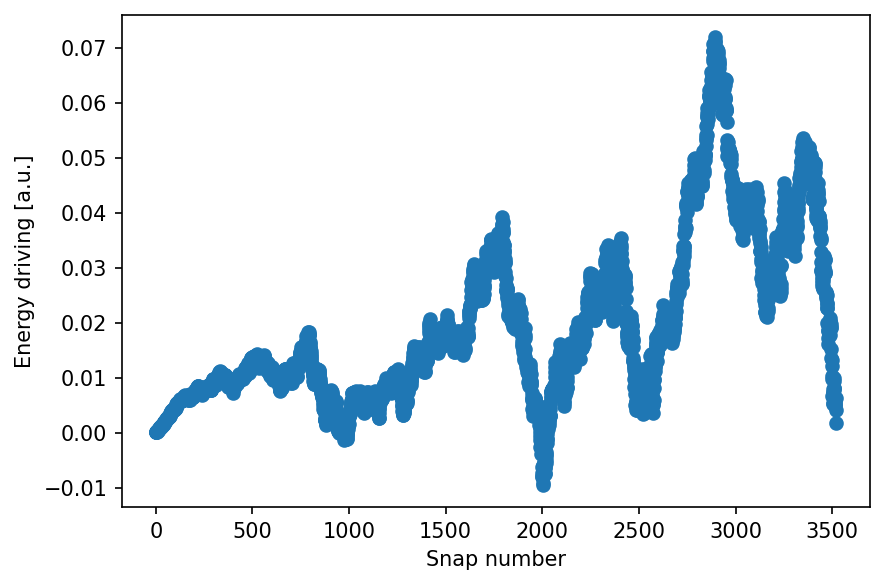

In [78]:
plot_injected_kinetic()

In [20]:
TURB_STAT_FNAME_TEMPLATE = "output/turbstat_{:04d}.dat"
NC = None


def read_turb_stat(i: int):
    global NC
    path = TURB_STAT_FNAME_TEMPLATE.format(i)
    if NC is None:
        with open(path, mode='rb') as file:
            file_content = file.read(4)
            NC = struct.unpack("i", file_content)[0]

    return np.fromfile(path, offset=4, dtype=np.double)


def get_available_shapshots():
    files = glob(TURB_STAT_FNAME_TEMPLATE[:-10] + "*")
    snapshot_numbers = [int(x[-8:-4]) for x in files]
    start, end = np.min(snapshot_numbers), np.max(snapshot_numbers)
    return start, end


#     for i, item in enumerate(np.arange(start, end, 1, dtype=int)):
#         data = read_turb_stat()


def plot_injected_kinetic():
    start, end = get_available_shapshots()
    energy_per_snap = np.zeros(end - start)
    for i, item in enumerate(np.arange(start, end, 1, dtype=int)):
        data = read_turb_stat(item)
        energy_per_snap[i] = data.sum()

    f, ax = plt.subplots(dpi=150)
    ax.scatter(np.arange(start, end, 1, dtype=int), energy_per_snap)
    ax.set_xlabel("Snap number")
    ax.set_ylabel("Energy driving [a.u.]")
    f.tight_layout()


def get_number_of_fields():
    files_in_output_dir = glob("output/*_0000.dat")
    assert len(files_in_output_dir) > 0, "Output files missing."
    return len(files_in_output_dir)


FNAME_TEMPLATE = "output/field_{}_{:04d}.dat"
NF = get_number_of_fields()


def read_field(path, npix=None, return_npix=False):
    if npix is None:
        with open(path, mode='rb') as file:
            file_content = file.read(4)
            npix = struct.unpack("i", file_content)[0]

    if return_npix:
        return npix, np.fromfile(path, offset=4,
                                 dtype=np.double).reshape(npix, npix)
    return np.fromfile(path, offset=4, dtype=np.double).reshape(npix, npix)


def get_vlimits(
    i_start: int,
    i_end: int,
    mode: str = 'percentile',
    percentiles: np.ndarray = (3, 97)) -> np.array:

    # parse inputs and do some validation
    assert (i_end > i_start)
    assert (mode in ('minmax', 'percentile'))
    if mode == 'percentile':
        assert (percentiles is not None)
        assert (len(percentiles) == 2)

    # read all data for one field and update the vlim array accordingly
    vlim = np.zeros((NF, 2))
    for f in range(NF):
        vmin = np.zeros(i_end - i_start)
        vmax = np.zeros(i_end - i_start)
        for i, item in tqdm(enumerate(range(i_start, i_end))):
            if f == 0 and item == i_start:
                npix, data = read_field(FNAME_TEMPLATE.format(f, i),
                                        return_npix=True)
            else:
                data = read_field(FNAME_TEMPLATE.format(f, i), npix=npix)
            if mode == 'minmax':
                vmin[i] = np.min(data)
                vmax[i] = np.max(data)
            elif mode == 'percentile':
                vmin[i] = np.percentile(data, percentiles[0])
                vmax[i] = np.percentile(data, percentiles[1])
        vlim[f, 0] = np.min(vmin)
        vlim[f, 1] = np.max(vmax)
    return vlim


def plot_timestep(i, vlim, logscale=False):
    # get the number of fields using glob
    files_in_output_dir = glob("output/*_0000.dat")
    assert len(files_in_output_dir) > 0, "Output files missing."
    nf = len(files_in_output_dir)

    # plot size and layout settings
    layout = [1, nf]
    figsize = (10, 2)
    if nf == 4:
        layout = (2, 2)
        figsize = (13, 13)
    fig, ax = plt.subplots(*layout, figsize=figsize, dpi=150)
    fig.set_facecolor('white')
    fig.suptitle("Timestep = {}".format(i), fontsize=30)
    ax.flatten()[0].set_title(r'$\rho$', fontsize=25)
    ax.flatten()[1].set_title(r'$v_x$', fontsize=25)
    ax.flatten()[2].set_title(r'$v_y$', fontsize=25)
    if nf == 4:
        ax.flatten()[3].set_title(r'$E_{tot}$', fontsize=25)
    elif nf == 5:
        ax.flatten()[3].set_title(r'$v_z$', fontsize=25)
        ax.flatten()[4].set_title(r'$E_{tot}$', fontsize=25)

#     plt.subplots_adjust(wspace=1, hspace=0)
    for f in range(nf):
        fname = FNAME_TEMPLATE.format(f, i)
        data = read_field(fname)

        # we only log density and energy
        if logscale:
            if f not in (1, 2, 3):
                data = np.log10(data)

        cax = ax.flatten()[f].imshow(data, vmin=vlim[f, 0], vmax=vlim[f, 1])
        fig.colorbar(cax, ax=ax.flatten()[f], fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.savefig('output/img/{:04d}.png'.format(i), transparent=False)
    del data
    plt.close(fig)


# vlims = get_vlimits(0, 1024)
vlims = np.array([[0.98406129, 1.00889139], [-0.14170206, 0.12495814],
                  [-0.19722257, 0.19967679], [1.46050438, 1.51649223]])
vlims = np.array([[0.99999024, 1.00000911], [-0.35980765, 0.28712435],
                  [-0.23604955, 0.3125268], [1.4999535, 1.50005032]])
vlims = np.array([[0.99996609, 1.00003566], [-0.92187798, 0.73605808],
                  [-0.60536087, 0.80085824], [1.49946989, 1.50053566]])

AssertionError: Output files missing.

In [7]:
get_vlimits(0, 16, mode="percentile")

16it [00:00, 178.53it/s]
16it [00:00, 102.84it/s]
16it [00:00, 96.46it/s] 
16it [00:00, 86.85it/s]


array([[ 0.99996609,  1.00003566],
       [-0.92187798,  0.73605808],
       [-0.60536087,  0.80085824],
       [ 1.49946989,  1.50053566]])

# density slice

In [ ]:
BASE_FOLDER = "/u/mihac/gpu_testbed/output/15-07-21-20-12-49/"


def plot_slice(i, path):
    data = plots.read_field(path + "data/field_0_{:04d}.dat".format(i))
    npix = data.shape[1]
    plot_data = data[:, npix // 2]

    x = np.arange(0, npix, 1, dtype=int)

    f, ax = plt.subplots(dpi=150)
    ax.set_xlabel("x")
    ax.set_ylabel(r"$\rho$")
    ax.set_xticks([0, npix])
    ax.set_xticklabels(["0", "1"])
    ax.plot(x, plot_data)
    f.tight_layout()
    f.savefig(path + "img/density_slice_{:04d}.jpg".format(i))
    plt.close(f)




In [12]:
start, stop = plots.get_available_shapshots(path=BASE_FOLDER)
NF = plots.get_number_of_fields(BASE_FOLDER)
vlims = plots.get_vlimits(start, stop)

func_plot = partial(plot_slice, path=BASE_FOLDER)
with Pool(20) as p:
    p.map(func_plot, range(start, stop))


No vlims.npy, calculating...


NameError: name 'NF' is not defined

In [9]:
bash_command = "/mpcdf/soft/SLE_15/packages/x86_64/ffmpeg/4.4.0/bin/ffmpeg -y -r 20 -i {}img/density_slice_%04d.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' {}/density_slice.mp4".format(
    BASE_FOLDER, BASE_FOLDER)
subprocess.call(bash_command, shell=True)

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --enable-nonfree --enable-gpl --enable-lv2 --enable-libsvtav1 --enable-libx264 --enable-libx265 --enable-libvpx --enable-libxvid --enable-libaom --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libtheora --enable-libwebp --disable-debug --disable-doc --disable-shared --enable-pthreads --enable-static --enable-small --enable-version3 --extra-cflags='-I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include -I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include/lilv-0' --extra-ldexeflags= --extra-ldflags=-L/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib --extra-libs='-ldl -lpthread -lm -lz' --pkgconfigdir=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib/pkgconfig --pkg-config-flags=--static --prefix=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace
  libavu

0

In [12]:
%%bash
/mpcdf/soft/SLE_15/packages/x86_64/ffmpeg/4.4.0/bin/ffmpeg -y -r 40 -i img/density_slice_%04d.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' density_slice.mp4;

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --enable-nonfree --enable-gpl --enable-lv2 --enable-libsvtav1 --enable-libx264 --enable-libx265 --enable-libvpx --enable-libxvid --enable-libaom --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libtheora --enable-libwebp --disable-debug --disable-doc --disable-shared --enable-pthreads --enable-static --enable-small --enable-version3 --extra-cflags='-I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include -I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include/lilv-0' --extra-ldexeflags= --extra-ldflags=-L/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib --extra-libs='-ldl -lpthread -lm -lz' --pkgconfigdir=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib/pkgconfig --pkg-config-flags=--static --prefix=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace
  libavu

CalledProcessError: Command 'b"/mpcdf/soft/SLE_15/packages/x86_64/ffmpeg/4.4.0/bin/ffmpeg -y -r 40 -i img/density_slice_%04d.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' density_slice.mp4;\n"' returned non-zero exit status 1.

In [15]:
data.shape[1]

640

In [11]:
data

array([[1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       [1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       [1.1, 1.1, 1.1, ..., 1.1, 1.1, 1.1],
       ...,
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 1. ],
       [1. , 1. , 1. , ..., 1. , 1. , 1. ]])

In [15]:
from functools import partial
func = partial(plot_timestep, vlim=vlims)
with Pool(20) as p:
    p.map(func, range(16))
# p.map(plot_timestep, range(1024));
# for i in tqdm(range(1024)):
#     plot_timestep(i, NF=NF)
#     fig, ax = plt.subplots(1, NF, figsize=(10, 2), dpi=150)
#     fig.suptitle("Timestep = {}".format(i))

#     ax[0].set_title(r'$\rho$')
#     ax[1].set_title(r'$v_x$')
#     ax[2].set_title(r'$v_y$')
#     ax[3].set_title(r'$v_z$')
# #     ax[4].set_title(r'$E_{tot}$')

#     plt.subplots_adjust(wspace=1, hspace=0)
#     for f in range(NF):
#         fname = 'output/field_{}_{:04d}.dat'.format(f, i)
#         data = read_field(fname)
#         if f in (1, 2, 3):
#             data = data + 1

#         cax = ax[f].imshow(np.log10(data))
#         #         plt.colorbar(cax)
#         fig.colorbar(cax, ax=ax[f], fraction=0.046, pad=0.04)

In [30]:
%%bash
/mpcdf/soft/SLE_15/packages/x86_64/ffmpeg/4.4.0/bin/ffmpeg -y -r 40 -i output/img/%04d.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' output/img/video.mp4;

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (GCC)
  configuration: --enable-nonfree --enable-gpl --enable-lv2 --enable-libsvtav1 --enable-libx264 --enable-libx265 --enable-libvpx --enable-libxvid --enable-libaom --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libmp3lame --enable-libopus --enable-libvorbis --enable-libtheora --enable-libwebp --disable-debug --disable-doc --disable-shared --enable-pthreads --enable-static --enable-small --enable-version3 --extra-cflags='-I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include -I/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/include/lilv-0' --extra-ldexeflags= --extra-ldflags=-L/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib --extra-libs='-ldl -lpthread -lm -lz' --pkgconfigdir=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace/lib/pkgconfig --pkg-config-flags=--static --prefix=/home/abuild/rpmbuild/BUILD/build-ffmpeg-4.4.0/workspace
  libavu

In [31]:
Video("output/img/video.mp4", embed=True, width=750, height=750, html_attributes='controls')

# diagnostics


In [174]:
fname_template = "/u/mihac/gpu_testbed/output/10-07-21_00:44:01/data/field_{}_{:04d}.dat"
npix, rho = read_field(fname_template.format(0, 0), return_npix=True)

In [186]:
rho.shape, rho.size

((640, 640), 409600)

In [183]:
mid = 320
idx = mid + mid * 640
idx

205120

In [187]:
rho.flatten()[idx-5:idx+5]

array([1. , 1. , 1. , 1. , 1. , 1.1, 1.1, 1.1, 1.1, 1.1])

In [203]:
where = np.argwhere(rho == 1.1)
mid_idx = (where.max() - where.min()) // 2 + where.min()


1.1

In [212]:
(where.max() - where.min()) // 2+ where.min()

339

(300.0, 380.0)

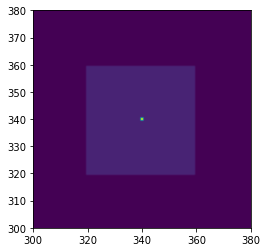

In [209]:
rho2 = rho * 1
rho2[mid_idx[0], mid_idx[0]] = 2
f, ax = plt.subplots()
ax.imshow(rho2)
ax.set_ylim(300, 380)
ax.set_xlim(300, 380)

In [130]:
field = rho
field = np.array(field)
xx, yy = np.meshgrid(np.arange(field.shape[0]), np.arange(field.shape[1]))
xx -= field.shape[0] // 2
yy -= field.shape[1] // 2
distance = np.sqrt(xx**2 + yy**2)

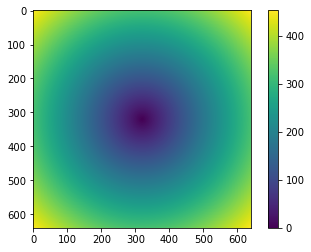

In [133]:
plt.imshow(distance)
plt.colorbar()

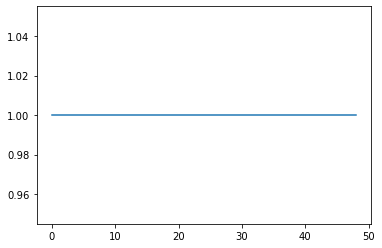

In [153]:
plt.plot(radial_profile(rho))